## Sentiment Analysis of Movie Reviews Using Naive Bayes 🎬

For this assignment we would like to know if we can use the Naive Bayes theorem to be an accurate classifier on a data set of movie reviews. This dataset was taken from the Kaggle dataset named "Bag of Words Meets Bag of Popcorn". The data consists of 50,000 IMBD movie reviews that do not include any personal information such as the persons' username or adress, or any other identifier that may cause harm. By understanding these are just personal opinions of people that we cannot identify, we deem this data set ethically safe to proceed.

Our main goal will be to answer the question, "Can we accurately predict the sentiment of a movie review using Naive Bayes?". We will also try to answer a second question of "Are we able to find words that most commonly belong to each sentiment?". The second question will be answered using the TfidfTransformer that will set weights to each word based on the importance of that word in the corresponding sentiment. We should expect to find positive words in the positive sentiments.

#### Notes
+ make a few different models and compare them
+ stemming/lemmatization
+ make a preprocessing functon that keeps only the important digits and removes the rest <br> 
  -Function to preprocess text <br>def preprocess_text(text): # Keep important numeric patterns (e.g., ratings) <br>text = re.sub(r'\d+\s*out\s*of\s*\d+|\d+\s*stars?', '', text) # Remove other numeric patterns <br>text = re.sub(r'\d+', '', text)
+ do sentence-level tokens and word-level

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# create data frame
df = pd.read_csv("../data/bag_of_words.csv", delimiter = ',')

In [4]:
# view first 5 rows
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [5]:
# check for null
df.tail()

,id,sentiment,review
24995,3453_3,0,It seems like more consideration has gone into...
24996,5064_1,0,I don't believe they made this film. Completel...
24997,10905_3,0,"Guy is a loser. Can't get girls, needs to buil..."
24998,10194_3,0,This 30 minute documentary Buñuel made in the ...
24999,8478_8,1,I saw this movie as a child and it broke my he...


In [6]:
# view the tail
df.tail()

,id,sentiment,review
24995,3453_3,0,It seems like more consideration has gone into...
24996,5064_1,0,I don't believe they made this film. Completel...
24997,10905_3,0,"Guy is a loser. Can't get girls, needs to buil..."
24998,10194_3,0,This 30 minute documentary Buñuel made in the ...
24999,8478_8,1,I saw this movie as a child and it broke my he...


We can see that our data is perfectly balanced so we will not have to worry about balancing the data later. This is important because it may make the accuracy of an unbalanced data set seem high when in reality it is not performing very well if one class is much more likely than the other.

<Axes: title={'center': 'Distribution of Sentiments'}, xlabel='sentiment'>

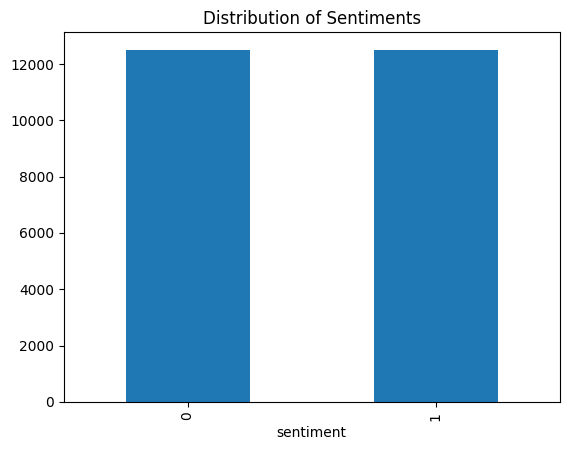

In [7]:
df['sentiment'].value_counts().sort_index().plot(kind = 'bar', title = 'Distribution of Sentiments')

In [8]:
# view value counts for sentiment
df['sentiment'].value_counts()

sentiment
1    12500
0    12500
Name: count, dtype: int64

In [9]:
# view 10 positive sentiments
df[df['sentiment'] == 1][:10]

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...
5,8196_8,1,I dont know why people think this is such a ba...
9,8713_10,1,<br /><br />This movie is full of references. ...
11,6811_10,1,Although I generally do not like remakes belie...
12,11744_9,1,"\Mr. Harvey Lights a Candle\"" is anchored by a..."
18,3304_10,1,This movie is one among the very few Indian mo...
19,9352_10,1,"Most people, especially young people, may not ..."
20,3374_7,1,"\Soylent Green\"" is one of the best and most d..."


Before moving any further we see '< br />' is present in the 9th index. This should be removed and we can use str.replace to replace this string with a space instead. Any other punctuation can be removed using a RegexpTokenizer later, but we can use the string replace method to keep the string pattern simpler in our RegexpTokenizer.

In [10]:
df.iloc[9]['review']

'<br /><br />This movie is full of references. Like \\Mad Max II\\", \\"The wild one\\" and many others. The ladybug´s face it´s a clear reference (or tribute) to Peter Lorre. This movie is a masterpiece. We´ll talk much more about in the future."'

In [11]:
# clean the text by replacing <br /> with a space
df['review'] = df['review'].str.replace('<br />', ' ')

In [12]:
# check that they have been removed
df.iloc[9]['review']

'  This movie is full of references. Like \\Mad Max II\\", \\"The wild one\\" and many others. The ladybug´s face it´s a clear reference (or tribute) to Peter Lorre. This movie is a masterpiece. We´ll talk much more about in the future."'

### Preprocessing Using Examples

In [13]:
# libraries needed for our sentiment analysis
import nltk
from nltk import word_tokenize
from nltk import sent_tokenize

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

The first thing we will have to do for our data is 'tokenize' the review. This means we will have to separate the string into separate words. We can do this using the **word_tokenize** function provided in nltk library. As we see from our example, every word is taken out of the string as its own entity and the punctuation also is included. The **word_tokenize** will use the Punkt Tokenizer which is a pre-trained tokenizer that is known to be highly effective. We can also tokenize on the sentence level and we will compare these results to the word level, later.

In [14]:
# example sentence to tokenize
example = 'This is an example of word level tokenizing.'

# print the results
word_toke = word_tokenize(example)
print(word_tokenize(example))

['This', 'is', 'an', 'example', 'of', 'word', 'level', 'tokenizing', '.']


In [15]:
# since it returns a list we can use indexing.
word_toke[0]

'This'

We can also tokenize at the sentence level so that every sentence is its own entity.

In [16]:
# example for sent_tokenize 
sentence_example = 'This is an example of sentence-level tokeizing. There should be two separate entities.'

# print the results
sent_toke = sent_tokenize(sentence_example)
print(sent_toke)

['This is an example of sentence-level tokeizing.', 'There should be two separate entities.']


In [17]:
# indexing results
sent_toke[1]

'There should be two separate entities.'

Since we will be using these reviews to classify them as being positive or negative, we can remove words that will appear in both positive and negative sentiments without describing the actual sentence. These are called 'stop words' and we have a few in our example sentence. We can import **stop_words** from **nltk**. After importing stop_words we can print the stop words to get an idea of what they are. We can also use the stop_words on our example to see how it is changed. This will clean our data. By looking at some of our reviews we can also see punctuation such as "/" that will have to be cleaned as well.

Before removing the stop words we should also remove our punctuation since **word_tokenize()** will separate them like any other word but include them in the tokenized version. This is why we should remove the punctuation before using **word_tokenize()**. Also, we should do this before using stop_words because they will be working with the tokenized string. In our data we saw there was a \, so after cleaning our data we should make sure to double check those rows to ensure it was removed with the punctuation. If it was not we can set up our own custom stop words.

In [18]:
# import stop words
from nltk.corpus import stopwords

In [19]:
# set a variable equal to the english stopwords
stop_words = set(stopwords.words('english'))

# print all english stop words
print(stop_words)

{'up', 's', 'same', "you're", "hasn't", "doesn't", 'before', 'him', 'should', "hadn't", 'for', 'after', 'aren', 'because', 'with', 'an', 'there', 'couldn', "she's", 'most', 'too', 'a', "you've", 'but', 'down', "you'll", 'don', 'about', 'again', 'who', 'until', 'how', 'as', 'we', 'or', "won't", 'y', 't', 'than', 've', 'shouldn', 'when', 'are', 'if', 'yours', "shouldn't", "don't", 'hasn', 'into', 'all', "it's", 'at', 'mightn', 'hers', 'over', 'and', 'our', 'needn', 'why', 'o', 'above', 'is', 'what', "should've", 'have', 'now', 'ourselves', "shan't", 'from', 'themselves', 'won', "haven't", 'itself', 'been', 'of', 'any', 'their', "wasn't", 'll', 'he', 'while', 'd', "aren't", 'against', 'm', 'me', 'some', 'such', 'then', 'both', 'that', 'each', 'were', 'wasn', 'she', 'being', 'more', 'which', 'shan', 're', 'his', 'under', 'be', 'only', 'can', 'few', 'didn', 'your', 'isn', "you'd", 'does', 'further', 'hadn', 'having', 'nor', 'you', 'on', 'those', 'off', "isn't", 'my', 'in', 'theirs', 'has', 

In [20]:
# import string to help us remove the punctuation and join letters to form words
import string

Now we should remove the punctuation since they do not help us make sense of sentiments. We will be tokenizing on the word level and we do not want punctuation to be its own entity that will recieve a value later in our calculations.

In [21]:
# make punctuation a set so it is faster
punctuation = set(string.punctuation)

# punctuation removal example
punc_example = 'Next, let"s remove the punctuation!'

# for loop to remove punctuation
punc_example1 = [char for char in punc_example if char not in punctuation]

# results
print(punc_example1)

['N', 'e', 'x', 't', ' ', 'l', 'e', 't', 's', ' ', 'r', 'e', 'm', 'o', 'v', 'e', ' ', 't', 'h', 'e', ' ', 'p', 'u', 'n', 'c', 't', 'u', 'a', 't', 'i', 'o', 'n']


Now we need to join the words together again since they have been pu into a list. The syntax for **join** is **separator.join(list)** and in our case we want to join the letters by seperating them on blank spaces so the separator is the empty space and everything between the empty space will be joined.

In [22]:
# join the words together based on the whitespace created from removing punctuation
punc_example1 = ''.join(punc_example1)

# print results
print(punc_example1)

Next lets remove the punctuation


A more efficient way is to use **translate** which does both steps at the same time. **maketrans** takes three arguments. The first argument is a string of characters that we want to replace. In our example, we do not want to replace any characters. The second argument is the string to replace the characters we wanted to replace them with which again is nothing in our case. The third argument is a string that we want to delete. This prevents us from having to create a for loop along with the join method.

In [23]:
punc_example2 = 'Next, let"s remove the punctuation!'
punc_example2 = punc_example2.translate(str.maketrans('', '', string.punctuation))
punc_example2

'Next lets remove the punctuation'

In [24]:
# use word_tokenize now then use stopwords
tokenized = word_tokenize(punc_example1)
tokenized

['Next', 'lets', 'remove', 'the', 'punctuation']

In [25]:
# remove the stop words with a function similar to our punctuation one. ('the')
filtered_sentence = [word for word in tokenized if not word.lower() in stop_words]

# print the results
print(filtered_sentence)

['Next', 'lets', 'remove', 'punctuation']


At this point our text data is cleaned but is not ready for any machine learning analysis. Our machine learning algorithm will have to work with numerical numbers so we will have to create a **document term matrix (DTM)**. This will assign each word to an integer in a matrix throughout our data. We can do this using **CountVectorizer** from **sklearn.feature_extraction.text**. We can demonstrate how this works on a single sentence before using it on all of our data.

In [26]:
# We can use CountVectorizer so that we are working with numbers
from sklearn.feature_extraction.text import CountVectorizer

Like many other modules in sklearn we will create an object then fit our data to the object then transform our data using the object. After fitting our test example to the **CountVectorizer** object we can use **.vocabulary_** to see what is happening. This has created a dictionary that stores each word as an integer. Our test sentiment has the word test listed two times so the dictionary only has test listed once. In our example, test is assigned to the value 2. We can also see that the stopwords have not been removed, but the word 'a' is gone because **CountVectorizer** counts words that are atleast two characters in length by default. We can add stop_words to the **CountVectorizer** and we will show this later.

In [27]:
# sentiment example
test = ["This is a test that's called test."]

# initiate a CountVectorizer object
vectorizer = CountVectorizer()

# fit the vectorizer on our data
vectorizer.fit(test)

# print the fitted data (not transformed yet)
print(vectorizer.vocabulary_)

{'this': 4, 'is': 1, 'test': 2, 'that': 3, 'called': 0}


In [28]:
# transform our data
vector = vectorizer.transform(test)
print(vector)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 5 stored elements and shape (1, 5)>
  Coords	Values
  (0, 0)	1
  (0, 1)	1
  (0, 2)	2
  (0, 3)	1
  (0, 4)	1


### Preprocessing Our Data

Now that we have run through some basic examples on what we have to do to the sentiments in our data we can use these techniques to preprocess our data. We went through numerous steps that included:
+ remove unwanted characters such as HTML tags 
+ convert all the text to lowercase
+ remove punctuation
+ tokenize
+ remove stop words

We can create a function that lists these steps and pass our dataframe into it.

A quick word on regex...
we can import **re** which helps us work with regular expressions. This will help us identify and transform/remove/replace certain characters in a document/corpus. Regex can be complicated and confusing since there are many different combinations with awkward syntax. Help can be found here: https://www3.ntu.edu.sg/home/ehchua/programming/howto/Regexe.html

We will be using **re.sub()** which has the following syntax:
+ re.sub(pattern, replacement, string), where pattern is what we want to identify, replacement is what we want to replace it with, and string is the string we are applying it to (such as a document).
+ since we identified some HTML tags in our initial data inspection, we will use the pattern r'<.*?>'
+ we want to replace the HTML tags with a blank space so we will use '' as the second argument. 
+ we are applying this transformation to our reviews data.

In [29]:
import re

def text_preprocessing(text):
    
    # step one - remove the tags
    text = re.sub(r'<.*?>', '', text)

    # step two - convert to lowercase so words are treated the same 
    text = text.lower()
    
    # step 3 - use translate to remove punctuation - translation needs a string so dont use set
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # step 4 - tokenize
    text = word_tokenize(text)

    # stop words
    text = [word for word in text if word not in stop_words]

    return text
    

In [30]:
# create a new column using the function 
data = df.copy()
data['preprocessed'] = data.iloc[:, 2].apply(text_preprocessing)

Now, we can view the old reviews and the preprocessed reviews side-by-side to see if we receive what is expected. The new column **preprocessed** has no HTML tags (such as <'br'>) that we saw, Everything is lowercase, there is no punctuation, the words have been tokenized into a list separated by commas, and stop words have been removed.

In [31]:
data.head(12)

,id,sentiment,review,preprocessed
0,5814_8,1,With all this stuff going down at the moment w...,"[stuff, going, moment, mj, ive, started, liste..."
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...","[classic, war, worlds, timothy, hines, enterta..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,"[film, starts, manager, nicholas, bell, giving..."
3,3630_4,0,It must be assumed that those who praised this...,"[must, assumed, praised, film, greatest, filme..."
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,"[superbly, trashy, wondrously, unpretentious, ..."
5,8196_8,1,I dont know why people think this is such a ba...,"[dont, know, people, think, bad, movie, got, p..."
6,7166_2,0,"This movie could have been very good, but come...","[movie, could, good, comes, way, short, cheesy..."
7,10633_1,0,I watched this video at a friend's house. I'm ...,"[watched, video, friends, house, im, glad, was..."
8,319_1,0,"A friend of mine bought this film for £1, and ...","[friend, mine, bought, film, £1, even, grossly..."
9,8713_10,1,This movie is full of references. Like \Mad ...,"[movie, full, references, like, mad, max, ii, ..."


After creating the function we can pass our column through using .apply() but since we are working with a large dataset it will take a long time making it computationally expensive. Luckily for us, we can use **RegexpTokenizer** from nltk.tokenize to speed up this process. When using **CountVectorizer** there are parameters for both stop words and tokenizer. We can pass through the english stopwords and create a tokenizer from nltk that will tokenize our words based on the pattern. When using the regexptokenizer we will state that we want our pattern to be all lower case and upper case letters and all numbers. By using this approach we cover all of our bases in the text_preprocessing function besides removing the tags. Since tags contain symbols and letters, we may introduce tokens such as "div" that we want to avoid. This means we can remove the tags then use **RegexpTokenizer** and everything will be covered.

In [32]:
from nltk.tokenize import RegexpTokenizer

This can streamline our preprocessing into just a few steps and run much faster than our apply method. Below we have a sample string that we will remove punctuation, stop words, tokenize, and transform into a **document term matrix**. First, we set up a **RegexpTokenizer** object with a pattern that we want to look for. This will remove the punctuation from our string. Then we set up our DTM by using a CountVectorizer and remove stopwords by stating 'english' in that parameter. Then, we use the tokenizer that we established as another parameter. The resulting matrix shows there are no stop words and that *machine* and *learning* are counted twice as they should be. This is basically the same thing we did above but now the process is streamlined for us.

**Document Term Matrix** - The DTM is a numerical representation of our text data. Each row of the matrix contains a document in the corpus. A corpus is just a collection of documents. Each column in the matrix represents a unique word in the corpus. The value within each cell corresponds to the count for that word, or a normalized form/binary indicator of presence/absence. If we do not use **Term Frequency - Inverse Document Frequency (TF-IDF)** they will just be the counts.

In the example below, we can see how this works for just one string. We use the **RegexpTokenizer** to tokenize our string based on the regex pattern which will inculde only numbers and letters. This is passed to the **CountVectorizer** construction which tells it to tokenize the words using our custom pattern. We also pass in english stop words so that process is handled for us as well. We set **token_pattern** to None because **CountVectorizer** has built in tokenizers that we can use if we would like. The default pattern for the **CountVectorizer** is **r'(?u)\b\w\w+\b'** which matches any alphabetical/numerical characters more than length=1 and underscores. This also ignores punctuation and symbols so it would work fine in our code. I am only using the **RegexpTokenizer** to show how it works.

In [33]:
# create a sample string
string_sample = ['I love machine --learning, Machine Learning 101 is fun.']

# set up a tokenizer looking for the pattern of letters or numbers
toke = RegexpTokenizer('[A-Za-z0-9]+')

# create a CountVectorizer using the parameters for stop words and our tokenizer
vec = CountVectorizer(stop_words='english', tokenizer= toke.tokenize, token_pattern=None)

# fit the CountVectorizer
dtm = vec.fit(string_sample)

# view the digits dictionary for the matrix
print(dtm.vocabulary_)

{'love': 3, 'machine': 4, 'learning': 2, '101': 0, 'fun': 1}


When we print the **dtm.vocabulary_** we can see the numerical representation of each word. 'Love' is 3, 'machine' is 4, 'learning' is 2, '101' is 0 and 'fun' is 1. We can transform the string that will create a matrix representation. Since this string is the only document in the corpus, they will all have 0 for the row. The coordinates represent the "Document Term" matrix so the Document is the row, and the Term is the column.

The coordinates (0, 0) means we are looking at our first document (only document in this case) and the term that cooresponds to 0 which is '101'. The value for this coordinate is 1 because the term '101' appears only one time. The coordinates (0, 2) have a value of 2 because the word associated with the number 2 is 'learning' and that appears in this document two times.



In [34]:
# create a variable for our matrix
matrix = dtm.transform(string_sample)

# print the matrix to make sure machine and learning are there twice.
print(matrix)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 5 stored elements and shape (1, 5)>
  Coords	Values
  (0, 0)	1
  (0, 1)	1
  (0, 2)	2
  (0, 3)	1
  (0, 4)	2


Now we will run a test to see how we tokenize data that is in our dataframe. We select the second row of our review column and tokenize that sentiment. This has removed any punctuation and next we would pass this tokenizer into our CountVectorizer.

In [35]:
# run a test on the second row (1 index)
data_test = data.iloc[1]['review']
data_test

'\\The Classic War of the Worlds\\" by Timothy Hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate H. G. Wells\' classic book. Mr. Hines succeeds in doing so. I, and those who watched his film with me, appreciated the fact that it was not the standard, predictable Hollywood fare that comes out every year, e.g. the Spielberg version with Tom Cruise that had only the slightest resemblance to the book. Obviously, everyone looks for different things in a movie. Those who envision themselves as amateur \\"critics\\" look only to criticize everything they can. Others rate a movie on more important bases,like being entertained, which is why most people never agree with the \\"critics\\". We enjoyed the effort Mr. Hines put into being faithful to H.G. Wells\' classic novel, and we found it to be very entertaining. This made it easy to overlook what the \\"critics\\" perceive to be its shortcomings."'

In [36]:
# create a tokenizer with all letters and numbers
data_toke = RegexpTokenizer('[A-Za-z0-9]+')
tokens = data_toke.tokenize(data_test)
print(tokens)

['The', 'Classic', 'War', 'of', 'the', 'Worlds', 'by', 'Timothy', 'Hines', 'is', 'a', 'very', 'entertaining', 'film', 'that', 'obviously', 'goes', 'to', 'great', 'effort', 'and', 'lengths', 'to', 'faithfully', 'recreate', 'H', 'G', 'Wells', 'classic', 'book', 'Mr', 'Hines', 'succeeds', 'in', 'doing', 'so', 'I', 'and', 'those', 'who', 'watched', 'his', 'film', 'with', 'me', 'appreciated', 'the', 'fact', 'that', 'it', 'was', 'not', 'the', 'standard', 'predictable', 'Hollywood', 'fare', 'that', 'comes', 'out', 'every', 'year', 'e', 'g', 'the', 'Spielberg', 'version', 'with', 'Tom', 'Cruise', 'that', 'had', 'only', 'the', 'slightest', 'resemblance', 'to', 'the', 'book', 'Obviously', 'everyone', 'looks', 'for', 'different', 'things', 'in', 'a', 'movie', 'Those', 'who', 'envision', 'themselves', 'as', 'amateur', 'critics', 'look', 'only', 'to', 'criticize', 'everything', 'they', 'can', 'Others', 'rate', 'a', 'movie', 'on', 'more', 'important', 'bases', 'like', 'being', 'entertained', 'which'

After running these tests and examples, we know what is happening to the data. After clarifying the results we see there are a few tokens that will not help us with our analysis. These include 'e' and 'g'. This can be prevented using the token_pattern default with the **CountVectorizer**. Now we are ready to implement this preprocessing on our dataframe. Printing the entire vocabulary in this case would be too much to gain a lot of insights from, but when we print the first 20 words we see that there is a potential problem with our document-term matrix/vocabulary. The default tokenizer in the **CountVectorizer** does not remove digits. We would think that digits can help us understand sentiments such as "this movie is a 10 out of 10!", or "5 stars!". However, we have vocabulary words such as "0083" that may not help us very much. This is something to keep an eye on and make note of for optimizations.

In [37]:
# create CountVectorizer using the stopwords and default tokenizer
count_vect = CountVectorizer(stop_words = 'english')

# fit our data to the CountVectorizer
our_count_vect = count_vect.fit(df['review'])

# create a sliceable data type
sorted_vocab = sorted(our_count_vect.vocabulary_.items(), key=lambda item:item[1])

# view (very long) vocabulary dictionary
print(sorted_vocab[:10])

[('00', 0), ('000', 1), ('0000000000001', 2), ('00001', 3), ('00015', 4), ('000s', 5), ('001', 6), ('003830', 7), ('006', 8), ('007', 9)]


These numbers go on for a very long time so they should definitely be taken care of which we will do when we optimize our model. In the following cell we also see many forms of the same word 'aesthetic' that would all be handled differently so we should look in to stemming and lemmatization.

In [38]:
# view more vocab
print(sorted_vocab[2000:2010])

[('aesthete', 2000), ('aesthetic', 2001), ('aesthetical', 2002), ('aesthetically', 2003), ('aestheticism', 2004), ('aesthetics', 2005), ('aetheist', 2006), ('aetherial', 2007), ('aetv', 2008), ('af', 2009)]


For now, we will just create a baseline model without stemming or lemmatizing or removing the numbers.

In [39]:
# transform our data
dtm = our_count_vect.transform(data['review'])

We can print the first sentence to see that it is very long and has the row number 0 along with the word that has been transformed into an integer. Many words have only been used one time. 

In [40]:
# print the first sentence. Using this slicing the syntax is [row:row+1] since the end slice is exlusive.
print(dtm[0:1])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 145 stored elements and shape (1, 74516)>
  Coords	Values
  (0, 439)	1
  (0, 1661)	1
  (0, 4855)	1
  (0, 5220)	1
  (0, 5469)	3
  (0, 6999)	1
  (0, 7353)	1
  (0, 7434)	1
  (0, 8461)	1
  (0, 9441)	1
  (0, 9608)	1
  (0, 10214)	1
  (0, 10530)	1
  (0, 11319)	1
  (0, 11556)	1
  (0, 12394)	1
  (0, 12873)	1
  (0, 13728)	1
  (0, 14220)	1
  (0, 14601)	1
  (0, 14634)	2
  (0, 15090)	1
  (0, 15486)	1
  (0, 16355)	1
  (0, 16681)	1
  :	:
  (0, 63538)	1
  (0, 63586)	1
  (0, 63685)	1
  (0, 63804)	1
  (0, 64292)	1
  (0, 65119)	1
  (0, 66257)	1
  (0, 66259)	1
  (0, 66350)	1
  (0, 68078)	1
  (0, 68095)	1
  (0, 68128)	1
  (0, 68340)	1
  (0, 69546)	1
  (0, 70245)	1
  (0, 70629)	2
  (0, 71283)	1
  (0, 71794)	1
  (0, 71797)	1
  (0, 71802)	1
  (0, 71958)	2
  (0, 71964)	1
  (0, 72599)	1
  (0, 73069)	1
  (0, 73306)	1


In [41]:
# second sentence
print(dtm[1:2])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 57 stored elements and shape (1, 74516)>
  Coords	Values
  (0, 2231)	1
  (0, 2918)	1
  (0, 3906)	1
  (0, 6095)	1
  (0, 8326)	2
  (0, 12617)	3
  (0, 13448)	1
  (0, 15559)	1
  (0, 15563)	3
  (0, 15729)	1
  (0, 18268)	1
  (0, 19402)	1
  (0, 20718)	1
  (0, 20966)	2
  (0, 21844)	1
  (0, 21968)	1
  (0, 21973)	2
  (0, 22084)	1
  (0, 23423)	1
  (0, 23507)	1
  (0, 23508)	1
  (0, 23708)	1
  (0, 24440)	2
  (0, 27833)	1
  (0, 28433)	1
  :	:
  (0, 43979)	2
  (0, 44037)	2
  (0, 45942)	1
  (0, 46362)	2
  (0, 47531)	1
  (0, 48939)	1
  (0, 48975)	1
  (0, 51122)	1
  (0, 53381)	1
  (0, 53923)	1
  (0, 54935)	1
  (0, 59587)	1
  (0, 60634)	1
  (0, 61965)	1
  (0, 62555)	1
  (0, 63840)	1
  (0, 66257)	1
  (0, 66693)	1
  (0, 66959)	1
  (0, 70846)	1
  (0, 71804)	1
  (0, 71958)	1
  (0, 72275)	2
  (0, 73332)	1
  (0, 73820)	1


### Building a Model

For this assignment, we will be using the Naive Bayes classifier algorithm as our model. In this model we will be specifically using the multinominal Naive Bayes algorithm to make predictions on the sentiments. We choose this type of Naive Bayes over others such as the Gaussian approach because the multinomial technique is known to work best with categorical or discrete variables whereas the Gaussian approach is used for continuous variables. This classifier works with probabilities and treats all variables as being independent. The variables in our data are the different words and they will be treated as being independent. This means the probability of a single word is not dependent on the occurence of any other word. As we have seen previously each word in our data will be given an integer as its ID. This means every sentence will be a collection of integers followed by the final class of the sentence being 1 for positive and 0 for negative. A simple illustration of a sentence consisting of the string "This movie is good" can be integers such as 0, 1, 2, 3 and the sentiment will be 1 for positive. These integers are then used in the formula to find the corresponding probabilities along with the final sentiment class. With over 10,000 reviews, we may find that the word "good" has a high probability of being classified as a positive sentiment. This is found using conditional probabilities. The Bayes' Theorem is as follows:

$$
P(A \vert B) = \frac{P(B \vert A) P(A)}{P(B)}
$$



The | symbol in the equation means "given" so we are solving the Probability(A given B has already occured). In our example we would multiply the probability that the sentiment is a 1 times the probability of each word in the sentence given the sentiment is a 1. The probability of B | A is the probability of the word given the sentiment. In a text classifyer the P(B) will be each of our features which are the independent words so we will have $x_{1}, x_{2}, ... x_{n}$ for each word in our phrases

This means $x_{0}$ can be a word such as "good" and we will find the probability of "good" given the probability that the sentiment is a 1. This probability is used on every sentence in our data, not just the sentence that we are looking at so we would look through all the sentences for the probability of "good" appearing | the sentiment was positive. As you can tell, this is a lot of arithmetic even though it is simple arithmetic, errors are likely to occur and many words are likely to be in a review, so the sklearn MultinominalNB comes in handy.

The first step in model building will be to train our model. We will use a train test split to train our model and then test that model on the test set. The X_train will consist of 80% of our reviews that have been transformed into a document term matrix and the y_train will be the sentiment. The model will learn from the document term matrix about what classifies it as being either a good or bad sentiment. 

In [42]:
# import library
from sklearn.model_selection import train_test_split

In [43]:
# split our data for training and testing
X_train, X_test, y_train, y_test = train_test_split(dtm, data['sentiment'], test_size = 0.2, random_state = 0)

In [44]:
# import the Naive Bayes algorithm
from sklearn.naive_bayes import MultinomialNB

In [45]:
# create a multinomial Naive Bayes object
MNB = MultinomialNB()

# fit to our data
model = MNB.fit(X_train, y_train)

In [46]:
# Evaluation and Predictions
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix


In [47]:
# make predictions
predicted = MNB.predict(X_test)

# print the accuracy
print(accuracy_score(y_test, predicted))


0.8682


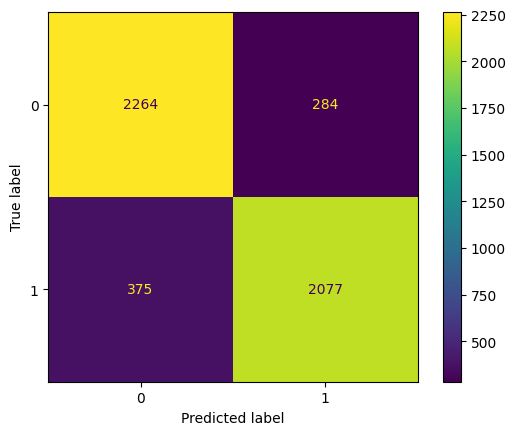

In [48]:
# confusion matrix
confusion_matrix = confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix).plot()

The results of our model are promising. Without any optimization we have achieved an accuracy score of 0.87. Since our data is balanced, this is a trustworthy metric. If our model was imbalanced we would not trust this metric as much. The f1 score of 0.86 tells us that we have a balanced trade off between precision and recall. Precision is useful for reducing the false positives. This tells us, "out of all the samples that have tested positive in our model, did we do well?" Recall is a measure where we look to reduce the false negatives. It takes all positive cases in the data and measures how we did with actual positives and false negatives. 

In [49]:
# f1 score  
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, predicted)
print(f'The f1 score for our first model is: {f1_score:.3f}')

# precision
from sklearn.metrics import precision_score
precision_score = precision_score(y_test, predicted)
print(f'The precision score for our first model is: {precision_score:.3f}')

# recall 
from sklearn.metrics import recall_score
recall_score = recall_score(y_test, predicted)
print(f'The recall score for our first model is: {recall_score:.3f}')



The f1 score for our first model is: 0.863
The precision score for our first model is: 0.880
The recall score for our first model is: 0.847


In [50]:
# classification report
from sklearn.metrics import classification_report

# show results
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      2548
           1       0.88      0.85      0.86      2452

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



The **ROC curve** is a popular metric when working with binary classifiers like we are in this assignment. The ROC curve is a plot of the true positive rate against the false positive rate. This can also be known as plotting sensitivity vs. 1 - specificity. A random classifier would have a diagonal line through the middle of the graph and the further we are towards the top left corner, the better the results. 

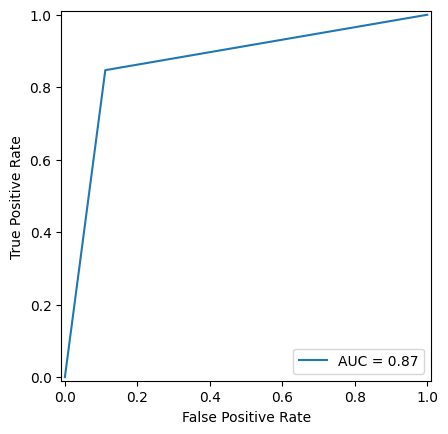

In [51]:
# ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(y_test, predicted)

# AUC 
auc = roc_auc_score(y_test, predicted)

# display results
roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = auc).plot()

We can use our model to make predictions on reviews that have not been made before. To do this, we pass our model followed by .predict(). In the predict function we will need to pass through the review but make sure that we transform it into a dtm first so we will use our_count_vect() and pass the new review in to it. We begin by making a prediction on a sentence that should be received positively and follow it up with a sentence that should be classified as a negative sentence. As a reminder, 1 = positive and 0 = negative.

In [52]:
# make predictions of a new sentiment that should be positive
model.predict(our_count_vect.transform(['I love this movie']))

array([1])

In [53]:
# make prediction of a new sentiment that should be negative
model.predict(our_count_vect.transform(['I hate this movie']))

array([0])

### Trying TFIDF and Other Methods for a Better Model

TfidfTransformer will transform our words and assign a weight to each word based on importance. The higher the value, the more important the word. For movie reviews we would assume that words like "movie" and "film" are present in many of the reviews whether they are good or bad sentiments. The tfidf assigns weights to words and words like "movie" and "film" would have a very low weight because they will not be adding much information as to what class they belong in when that word is present. In this sentence we see the word that was given the integer value of 6999 has high significance. We can see what this integer is in a word form. This word turns out to be 'bestest' which we would think should be used highly in a positive sentiment so we can check if this was indeed a positive sentiment. (1 = positive)

In [54]:
# import the TfidfTransformer from sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfTransformer

Here we create a variable tfidf_transformer and create the transformer. In the same line we also fit and transform our data by passing through the variable dtm. The variable dtm is our CountVectorizer after we removed the stop words, tokenized the data and fit_transformed the data. The data that was transformed was the 'review' column of our data that we stored as a dataframe called df. 

In [55]:
# fit and transform our data 
tfidf_transformer = TfidfTransformer().fit_transform(dtm)

print(tfidf_transformer[0:1])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 145 stored elements and shape (1, 74516)>
  Coords	Values
  (0, 439)	0.03786266121055409
  (0, 1661)	0.03705461472895983
  (0, 4855)	0.03568469200681955
  (0, 5220)	0.027081399509298942
  (0, 5469)	0.05951780847239651
  (0, 6999)	0.08138745504845976
  (0, 7353)	0.056178590803362655
  (0, 7434)	0.026602028203416065
  (0, 8461)	0.030901312893232377
  (0, 9441)	0.04738433008710627
  (0, 9608)	0.036783680873822965
  (0, 10214)	0.030762666092307676
  (0, 10530)	0.035095710219790154
  (0, 11319)	0.037123785372486846
  (0, 11556)	0.02144576414508846
  (0, 12394)	0.03279477747557416
  (0, 12873)	0.0538741109788088
  (0, 13728)	0.04186189309148528
  (0, 14220)	0.07576189121362456
  (0, 14601)	0.039849955213600276
  (0, 14634)	0.07148616110791199
  (0, 15090)	0.02789332056271856
  (0, 15486)	0.04454302824792021
  (0, 16355)	0.039785414332347536
  (0, 16681)	0.031147022063853554
  :	:
  (0, 63538)	0.033953568328399644
  (0, 63586)	0.03

This brings us to our second question that we were trying to solve when starting this project. We would like to be able to extract the word that is of high importance to see if it makes sense from a common knowledge standpoint. We would like to see a positive word associated with a positive sentiment which will also be a way to check that our model is performing correctly. To find out which word belongs to the integer value given in the CountVectorizer/TfidfTransformer, we use the count_vect variable which is the CountVectorizer that removes stop words and tokenizes the words before we fit and transform our column of interest. We then pass .get_feature_names_out() followed by the number of interest to return its original word.

In [56]:
# print the value to an important key in the sentence
count_vect.get_feature_names_out()[6999]

'bestest'

To see what sentiment this sentence had we can use iloc['row number']['sentiment column'] to return the sentiment that contained this sentence. 

In [57]:
# 'bestest' sounds like a word that would indicate a positive sentiment. Check it.
data.iloc[0]

id                                                         5814_8
sentiment                                                       1
review          With all this stuff going down at the moment w...
preprocessed    [stuff, going, moment, mj, ive, started, liste...
Name: 0, dtype: object

### Using Tfidf in Our Model

To use Tfidf in our model we will need to split the data again this time using the tfidf_transformer as the predictor and the sentiment from our dataframe as the target column. To fit the data we can use the MNB model that we created previously and pass through our new X_train, y_train.

In [58]:
# split the data using the Tfidf
X_train_tfidf, X_test_tfidf, y_train_, y_test = train_test_split(tfidf_transformer, data['sentiment'], test_size = 0.2, random_state = 0)

# fit the model to new splits
model_tfidf = MNB.fit(X_train_tfidf, y_train)


In [59]:
# make predictions
predicted_tfidf = model_tfidf.predict(X_test_tfidf)

In [60]:
from sklearn import metrics
# accuracy score
score = metrics.accuracy_score(predicted_tfidf, y_test)

This performs very similarly to our model, but slightly better. Overall, both of these models are fairly accurate and can produce good results for us if we are to implement them. 

In [61]:
# print our score
score * 100

87.44

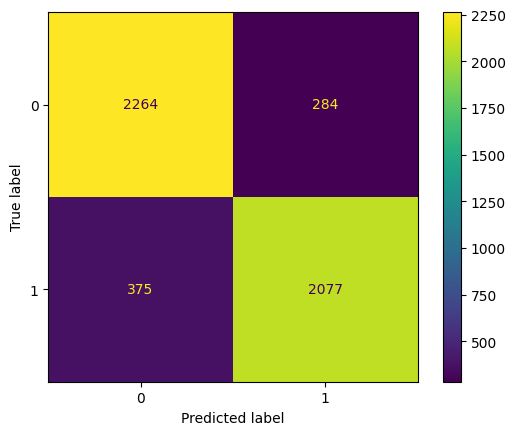

In [62]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix).plot()

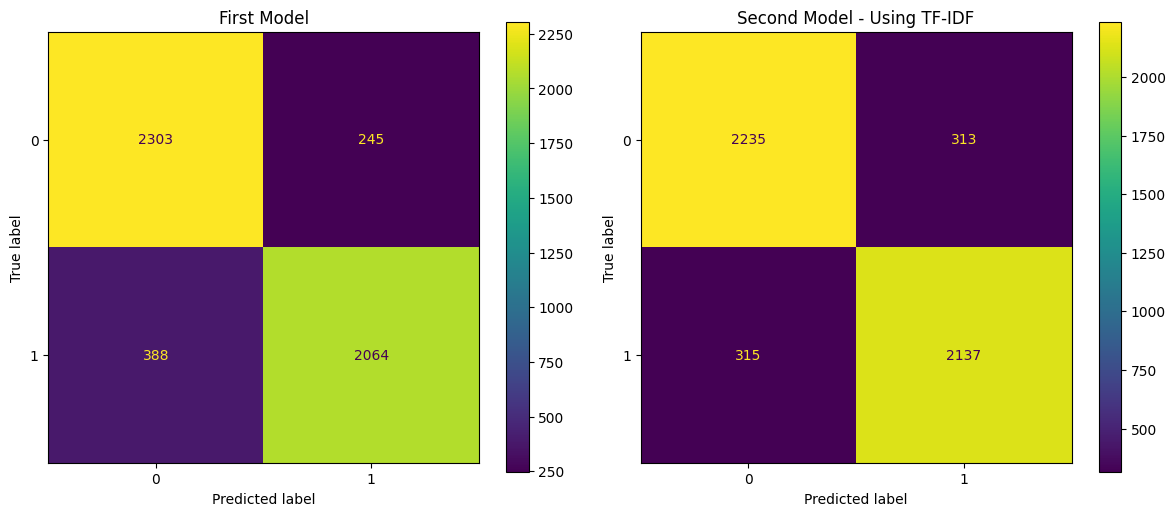

In [63]:
# plot both confusion matrices
# plot set up - 1 row, 2 cols
fig, axes = plt.subplots(1, 2, figsize=(12,5))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axes[0])
axes[0].title.set_text('First Model')

ConfusionMatrixDisplay.from_estimator(model_tfidf, X_test_tfidf, y_test, ax = axes[1])
axes[1].title.set_text('Second Model - Using TF-IDF')

plt.tight_layout()
plt.show()

In [64]:
# Generate classification reports
report1 = classification_report(y_test, predicted, output_dict=True)
report2 = classification_report(y_test, predicted_tfidf, output_dict=True)

# Convert classification reports to DataFrames
report_df1 = pd.DataFrame(report1).transpose()
report_df2 = pd.DataFrame(report2).transpose()


In [65]:
report_df1.drop(columns='support', inplace=True)
report_df2.drop(columns='support', inplace=True)

In [66]:
# rename columns so they can be distinguished
report_df2.rename(columns={'precision': 'precision_tfidf', 'recall': 'recall_tfidf', 'f1-score': 'f1-score_tfidf'}, inplace=True)
report_df1.rename(columns={0: 'Negative Sentiment', 1: 'Positive Sentiment'}, inplace=True)
report_df2.rename(columns={0: 'Negative Sentiment', 1: 'Positive Sentiment'}, inplace=True)
# concatenate the two DataFrames
reports = pd.concat([report_df1, report_df2], axis=1)
reports

,precision,recall,f1-score,precision_tfidf,recall_tfidf,f1-score_tfidf
0,0.857901,0.888540,0.872952,0.876471,0.877159,0.876814
1,0.879712,0.847064,0.863079,0.872245,0.871533,0.871889
accuracy,0.868200,0.868200,0.868200,0.874400,0.874400,0.874400
macro avg,0.868806,0.867802,0.868015,0.874358,0.874346,0.874352
weighted avg,0.868597,0.868200,0.868110,0.874398,0.874400,0.874399


### Cross-Validation

Before submitting our model for deployment we should cross validate it using kfolds. We will choose 10 folds to split up our data into training and testing. This ensures that the model is not learning specific information so that it will perform poorly when tested. The train test splits are done ten different times in this case and the results are fairly similar which means we can trust that our model will perform around the 86% accuracy rate that it got.

In [67]:
from sklearn.model_selection import KFold, cross_val_score 

In [68]:
# cross-validation variable
cv = KFold(n_splits=10, random_state=0, shuffle=True)

In [69]:
scores = cross_val_score(model, dtm, df['sentiment'],
                         cv=cv, n_jobs=-1)

In [70]:
scores.mean()

np.float64(0.858)

In [71]:
model_tfidf_scores = cross_val_score(model_tfidf, tfidf_transformer, data['sentiment'], cv=cv, n_jobs=-1)

In [72]:
model_tfidf_scores


array([0.878 , 0.8772, 0.8624, 0.8616, 0.8668, 0.8596, 0.862 , 0.8652,
       0.8684, 0.8592])

In [73]:
model_tfidf_scores.mean()

np.float64(0.8660400000000001)

#### Removing Numbers

Let's see if we can create our own **RegexpTokenizer** with a pattern that will remove all digits besides things like "5 stars" but remove all other digits. We will also make it so that the pattern includes all alphabetical tokens 2 or more characters in length.

In [74]:
# create copy of the data
data_copy = df.copy()

In [75]:
# Define the custom tokenizer pattern 
pattern = r'\d+\s*out\s*of\s*\d+|\d+\s*stars?|[a-zA-Z]{2,}' 
# Initialize the RegexpTokenizer with the custom pattern 
custom_tokenizer = RegexpTokenizer(pattern) 
# Example text 
sample_text = "I gave it 5 out of 5 stars and in 2020, I watched 50 movies." 
# Tokenize the text using the custom tokenizer 
tokens = custom_tokenizer.tokenize(sample_text) 
print("Tokenized Text:", tokens)

Tokenized Text: ['gave', 'it', '5 out of 5', 'stars', 'and', 'in', 'watched', 'movies']


In [86]:
# create a CountVectorizer
# create CountVectorizer using the stopwords and default tokenizer
custom_count_vect = CountVectorizer(stop_words = 'english', tokenizer=custom_tokenizer.tokenize)

# fit our data to the CountVectorizer
our_count_vect = custom_count_vect.fit(data_copy['review'])

# create a sliceable data type
sorted_vocab = sorted(our_count_vect.vocabulary_.items(), key=lambda item:item[1])

# view (very long) vocabulary dictionary
print(sorted_vocab[10:20])

c:\Users\ryans\Documents\Machine Learning GCU\Sentiment Analysis\.venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[('1 stars', 10), ('10 out of 10', 11), ('10 out of 9', 12), ('10 star', 13), ('10 stars', 14), ('100 stars', 15), ('1000 star', 16), ('10star', 17), ('11 out of 10', 18), ('12 out of 10', 19)]


In [87]:
len(our_count_vect.vocabulary_)

72983

Now that we have the new tokenized words we will use the **TfidTransformer** again since it performed better than the model that did not use it.

In [88]:
# transform our data
dtm_digits = our_count_vect.transform(data_copy['review'])

# fit and transform our data 
tfidf_transformer_digits = TfidfTransformer().fit_transform(dtm_digits)

In [89]:
# split the data
X_train_digits, X_test_digits, y_train_, y_test = train_test_split(tfidf_transformer_digits, data_copy['sentiment'], test_size = 0.2, random_state = 0)

# create a multinomial Naive Bayes object
MNB = MultinomialNB()
# fit the model to new splits
model_tfidf_digits = MNB.fit(X_train_digits, y_train)


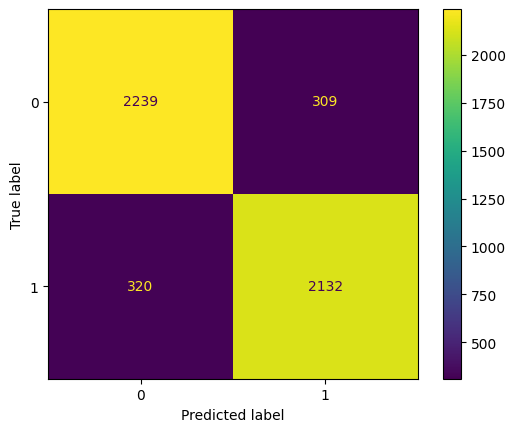

In [92]:
# make predictions
predicted_tfidf_digits = model_tfidf_digits.predict(X_test_digits)
# confusion matrix
ConfusionMatrixDisplay.from_estimator(model_tfidf_digits, X_test_digits, y_test)
plt.show()

In [93]:
print(classification_report(y_test, predicted_tfidf_digits))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2548
           1       0.87      0.87      0.87      2452

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



In [94]:
# Generate classification reports
report3 = classification_report(y_test, predicted_tfidf_digits, output_dict=True)


# Convert classification reports to DataFrames
report_df3 = pd.DataFrame(report3).transpose()


In [95]:
report3_df = pd.DataFrame(report3).transpose()
report3_df.drop(columns='support', inplace=True)
report3_df.rename(columns={'precision': 'precision_digits', 'recall': 'recall_digits', 'f1-score': 'f1-score_digits'}, inplace=True)

This model performs very similarly to the other models but uses less features without hindering performance so this would now be the best model.

In [96]:
reports = pd.concat([reports, report3_df], axis=1)
reports

,precision,recall,f1-score,precision_tfidf,recall_tfidf,f1-score_tfidf,precision_digits,recall_digits,f1-score_digits
0,0.857901,0.888540,0.872952,0.876471,0.877159,0.876814,0.874951,0.878728,0.876836
1,0.879712,0.847064,0.863079,0.872245,0.871533,0.871889,0.873413,0.869494,0.871449
accuracy,0.868200,0.868200,0.868200,0.874400,0.874400,0.874400,0.874200,0.874200,0.874200
macro avg,0.868806,0.867802,0.868015,0.874358,0.874346,0.874352,0.874182,0.874111,0.874142
weighted avg,0.868597,0.868200,0.868110,0.874398,0.874400,0.874399,0.874197,0.874200,0.874194


##### Logistic Regression Model

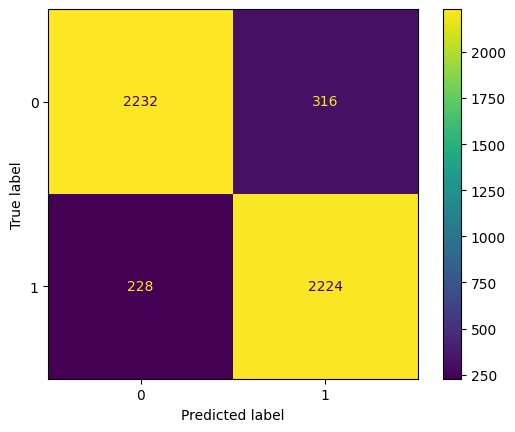

In [97]:
from sklearn.linear_model import LogisticRegression

# create a logistic regression object
log_reg = LogisticRegression()
# fit the model to new splits
model_log_reg = log_reg.fit(X_train_digits, y_train)
# make predictions
predicted_log_reg = model_log_reg.predict(X_test_digits)
# confusion matrix
ConfusionMatrixDisplay.from_estimator(model_log_reg, X_test_digits, y_test)
plt.show()

In [98]:
# classification report
print(classification_report(y_test, predicted_log_reg))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      2548
           1       0.88      0.91      0.89      2452

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



##### Random Forest Model

In [99]:
from sklearn.ensemble import RandomForestClassifier

# create a random forest object
rf = RandomForestClassifier()
# fit the model to new splits
model_rf = rf.fit(X_train_digits, y_train)
# make predictions
predicted_rf = model_rf.predict(X_test_digits)

#### References

Grus, J. (2015). Data Science From Scratch. O’Reilly Media, Inc.

Harrington, P. (2012). Machine Learning in Action. Manning Publications Co.

Patel, D. (2019). Machine Learning Tutorial Python 12 - K Fold Cross Validation[Video]. https://www.youtube.com/watch?v=gJo0uNL-5Qw&t=2s

Latrose, D., Latrose, C. (2015). Data Mining and Predictive Analysis. John Wiley & Sons